**Link Prediction using Graph Neural Networks**


In [31]:
# Import libraries
import torch
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.utils import negative_sampling
from torch_geometric.transforms import Compose, NormalizeFeatures, RandomLinkSplit
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc, ConfusionMatrixDisplay, confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Check for device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Data Preprocessing
def load_and_preprocess_data(file_path, node_feature_cols):
    df = pd.read_csv(file_path)
    unique_nodes = pd.unique(df[['u', 'v']].values.ravel())
    node_mapping = {old_id: new_id for new_id, old_id in enumerate(unique_nodes)}

    df['u'] = df['u'].map(node_mapping)
    df['v'] = df['v'].map(node_mapping)

    num_nodes = len(unique_nodes)
    node_features = np.zeros((num_nodes, len(node_feature_cols)))

    for i, col in enumerate(node_feature_cols):
        aggregated = df.groupby('u')[col].mean().reindex(range(num_nodes)).fillna(0)
        node_features[:, i] = aggregated.values

    node_features = torch.tensor(node_features, dtype=torch.float).to(device)
    edge_index = torch.tensor(df[['u', 'v']].values.T, dtype=torch.long).to(device)

    data = Data(x=node_features, edge_index=edge_index)
    return data, len(unique_nodes)

In [3]:
# Define Link Prediction GNN Model
class LinkPredictionGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.fc = torch.nn.Linear(2 * hidden_channels, 1)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_index):
        z_src, z_dst = z[edge_index[0]], z[edge_index[1]]
        edge_features = torch.cat([z_src, z_dst], dim=1)
        return self.fc(edge_features).squeeze()

# Train function
def train(model, optimizer, criterion, data, num_nodes):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x, data.edge_index)
    
    pos_out = model.decode(z, data.edge_label_index)
    neg_edge_index = negative_sampling(data.edge_index, num_nodes=num_nodes)
    neg_out = model.decode(z, neg_edge_index)
    
    out = torch.cat([pos_out, neg_out], dim=0)
    target = torch.cat([data.edge_label, torch.zeros(neg_out.size(0), device=device)], dim=0)
    
    loss = criterion(out, target)
    loss.backward()
    optimizer.step()
    return loss

# Test function
@torch.no_grad()
def test(model, data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).sigmoid()  # Use sigmoid for probability
    return out

# Threshold Optimization Function
def find_best_threshold(true_labels, predictions):
    thresholds = np.linspace(0.0, 1.0, num=100)  # Search over 100 thresholds from 0 to 1
    best_threshold = 0.0
    best_f1 = 0.0
    best_auc = 0.0

    for threshold in thresholds:
        pred_labels = (predictions > threshold).astype(int)
        f1 = f1_score(true_labels, pred_labels)
        auc = roc_auc_score(true_labels, predictions)

        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
        if auc > best_auc:
            best_auc = auc

    return best_threshold, best_f1, best_auc

In [4]:
# Plotting functions
def plot_roc_curve(fpr, tpr, roc_auc):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.grid()
    plt.show()

def plot_confusion_matrix(conf_matrix, title='Confusion Matrix'):
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["No Link", "Link"])
    disp.plot(cmap='Blues', values_format='d')
    plt.title(title)
    plt.show()

def plot_metrics(val_f1_scores, test_f1_scores, val_aucs, test_aucs, epochs):
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, epochs + 1), val_f1_scores, label="Validation F1 Score")
    plt.plot(range(1, epochs + 1), test_f1_scores, label="Test F1 Score")
    plt.plot(range(1, epochs + 1), val_aucs, label="Validation AUC")
    plt.plot(range(1, epochs + 1), test_aucs, label="Test AUC")
    plt.xlabel("Epochs")
    plt.ylabel("Metrics")
    plt.title("Model Performance Metrics Over Epochs")
    plt.legend(loc="best")
    plt.show()

Epoch: 001, Loss: 0.6796, Val F1: 0.6730, Test F1: 0.6672, Val AUC: 0.6991, Test AUC: 0.7113
Epoch: 002, Loss: 0.6335, Val F1: 0.7414, Test F1: 0.7439, Val AUC: 0.7205, Test AUC: 0.7315
Epoch: 003, Loss: 0.5895, Val F1: 0.7678, Test F1: 0.7690, Val AUC: 0.7241, Test AUC: 0.7346
Epoch: 004, Loss: 0.5634, Val F1: 0.7801, Test F1: 0.7795, Val AUC: 0.7257, Test AUC: 0.7366
Epoch: 005, Loss: 0.5818, Val F1: 0.7749, Test F1: 0.7759, Val AUC: 0.7317, Test AUC: 0.7431
Epoch: 006, Loss: 0.5894, Val F1: 0.7826, Test F1: 0.7833, Val AUC: 0.7388, Test AUC: 0.7515
Epoch: 007, Loss: 0.5781, Val F1: 0.7633, Test F1: 0.7676, Val AUC: 0.7472, Test AUC: 0.7613
Epoch: 008, Loss: 0.5659, Val F1: 0.7762, Test F1: 0.7809, Val AUC: 0.7573, Test AUC: 0.7727
Epoch: 009, Loss: 0.5623, Val F1: 0.7992, Test F1: 0.8009, Val AUC: 0.7669, Test AUC: 0.7828
Epoch: 010, Loss: 0.5652, Val F1: 0.8164, Test F1: 0.8206, Val AUC: 0.7756, Test AUC: 0.7919
Epoch: 011, Loss: 0.5691, Val F1: 0.8218, Test F1: 0.8275, Val AUC: 0.

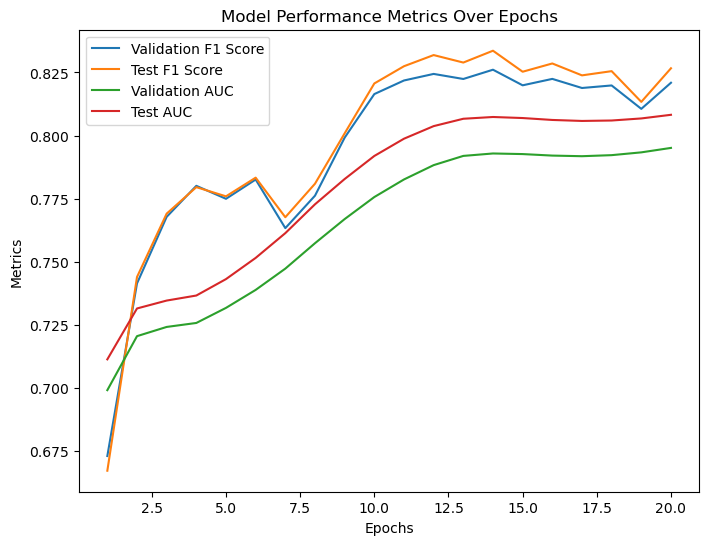

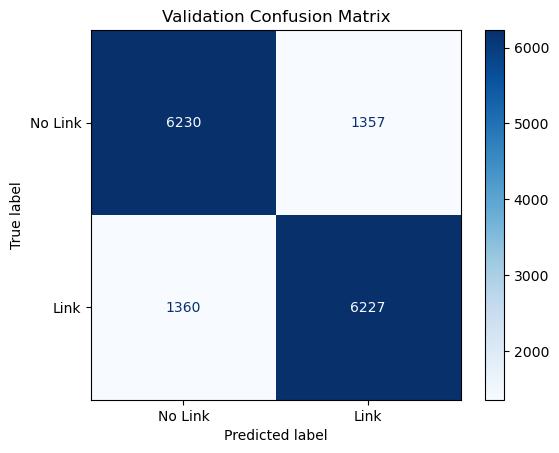

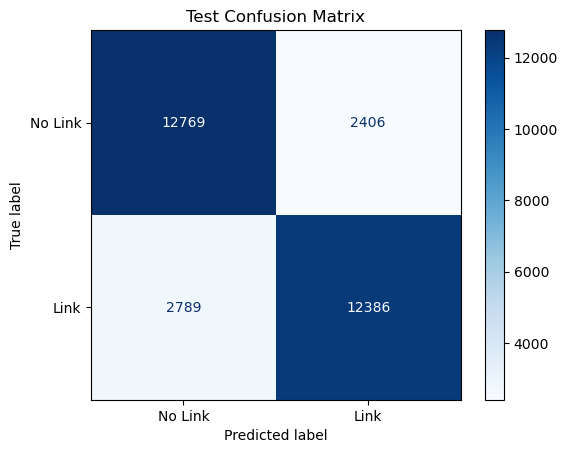

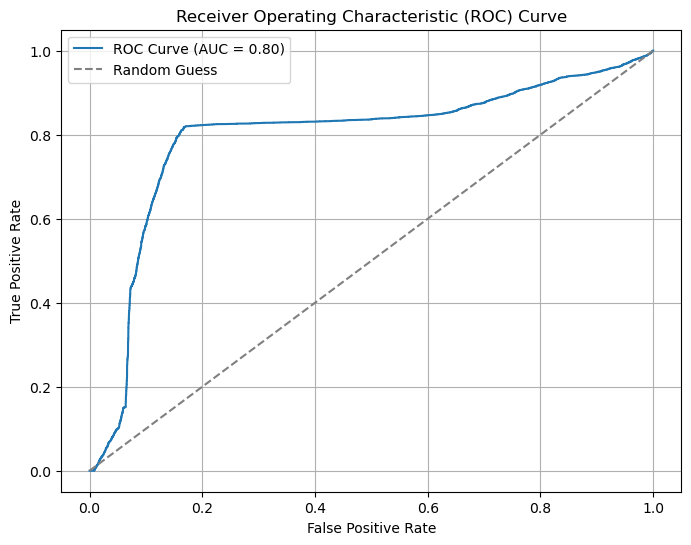

In [30]:
# Main execution
def main():
    # Load and preprocess data
    file_path = "set_with_features.csv"
    node_feature_cols = ['degree_u', 'degree_v', 'cluster_u', 'cluster_v', 
                         'nooffollowers_u', 'nooffollowees_u', 
                         'nooffollowers_v', 'nooffollowees_v', 
                         'pagerank_u', 'pagerank_v']
    data, num_nodes = load_and_preprocess_data(file_path, node_feature_cols)
    
    # Data split
    transform = Compose([NormalizeFeatures(), RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True)])
    train_data, val_data, test_data = transform(data)
    
    # Model initialization
    in_channels = data.x.size(1)
    hidden_channels = 64
    model = LinkPredictionGNN(in_channels, hidden_channels).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = torch.nn.BCEWithLogitsLoss()

    # Metrics and training loop
    best_val_auc = final_test_auc = 0
    val_aucs, test_aucs, val_f1_scores, test_f1_scores = [], [], [], []
    epochs = 20
    
    # Learning Rate Scheduler
    # StepLR: Decays the learning rate of each parameter group by gamma every step_size epochs
    # step_size=4: Reduces the learning rate every 4 epochs.
    # gamma=0.8: Multiplies the learning rate by 0.8 at each step.
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.85)

    # Training loop with learning rate scheduler
    for epoch in range(1, epochs + 1):
        model.train()
        loss = train(model, optimizer, criterion, train_data, num_nodes)
        scheduler.step()  # Step the scheduler to adjust learning rate
        
        # Evaluation on validation and test sets
        val_out = test(model, val_data)
        test_out = test(model, test_data)
        
        # Dynamically optimize threshold based on validation AUC and F1
        threshold, val_f1, val_auc = find_best_threshold(val_data.edge_label.cpu().numpy(), val_out.cpu().numpy())
        
        val_predictions = (val_out > threshold).long().cpu().numpy()
        test_predictions = (test_out > threshold).long().cpu().numpy()
        test_f1 = f1_score(test_data.edge_label.cpu().numpy(), (test_out.cpu().numpy() > threshold).astype(int))
        test_auc = roc_auc_score(test_data.edge_label.cpu().numpy(), test_out.cpu().numpy())

        # Save best model if validation AUC improves
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            final_test_auc = test_auc
            
        val_f1_scores.append(val_f1)
        test_f1_scores.append(test_f1)
        val_aucs.append(val_auc)
        test_aucs.append(test_auc)

        # Print epoch results
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val F1: {val_f1:.4f}, Test F1: {test_f1:.4f}, '
            f'Val AUC: {val_auc:.4f}, Test AUC: {test_auc:.4f}')
        
    # Final results
    print(f'Final Test AUC: {final_test_auc:.4f}')

    
    # Plot metrics
    plot_metrics(val_f1_scores, test_f1_scores, val_aucs, test_aucs, epochs)
    
    # Evaluate confusion matrix
    val_conf_matrix = confusion_matrix(val_data.edge_label.cpu().numpy(), val_predictions)
    test_conf_matrix = confusion_matrix(test_data.edge_label.cpu().numpy(), test_predictions)
    
    plot_confusion_matrix(val_conf_matrix, title='Validation Confusion Matrix')
    plot_confusion_matrix(test_conf_matrix, title='Test Confusion Matrix')
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(val_data.edge_label.cpu().numpy(), val_out.cpu().numpy())
    roc_auc = auc(fpr, tpr)
    plot_roc_curve(fpr, tpr, roc_auc)
    
# Execute the main function
if __name__ == "__main__":
    main()